# Image Classification through Convolutional Neural Networks in TensorFlow 2

## Requirements

- Pillow (`python3 -m pip install --upgrade pip; python3 -m pip install --upgrade Pillow`)
- TensorFlow (`python3 -m pip install tensorflow`)

## Disclaimer

This is the completion of the tutorial at [Image classification | TensorFlow Core](https://www.tensorflow.org/tutorials/images/classification#overfitting).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Fetch dataset

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 36s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


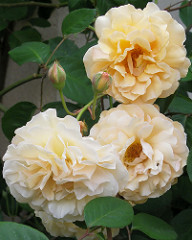

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

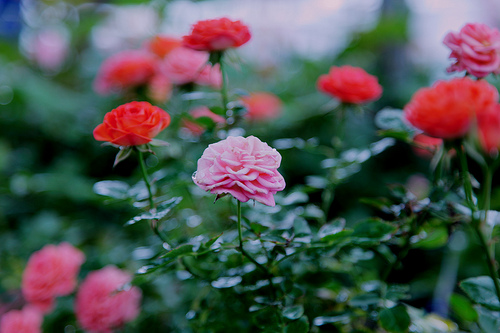

In [8]:
PIL.Image.open(str(roses[1]))

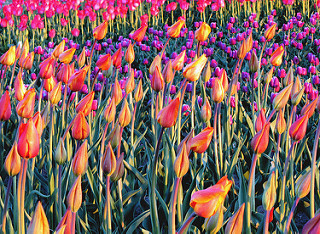

In [11]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Preprocess Dataset

We use a validation split of 0.2, meaning that 80% of the data is used for training, and 20% for validation

In [14]:
data_dir

PosixPath('/Users/helkebir/.keras/datasets/flower_photos')

In [15]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Labels are assigned based on the directory the files are in; these are known as the class names:

In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


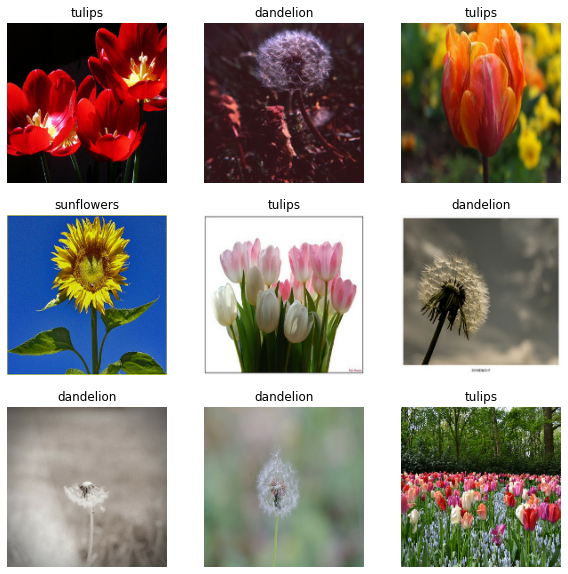

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Define Model

Here, we allocate memory to the training and validation datasets to ensure that the process runs smoothly. Usually the datasets will be stored in memory (RAM), but if there is not enough space, TensorFlow will create an on-disk cache.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

We now define a preprocessing routines:
- `normalization_layer` : We normalize the color range to [0, 1]

In [22]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Here, the model itself is defined, including the preprocessing layer.

In [23]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

We now compile the model and specify that it is solved using the Adam algorithm (a stochastic gradient descent method).

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train Model

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 34s 365ms/step - loss: 1.4804 - accuracy: 0.3702 - val_loss: 1.1592 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 33s 363ms/step - loss: 1.1301 - accuracy: 0.5450 - val_loss: 1.0329 - val_accuracy: 0.5722
Epoch 3/10
92/92 [==============================] - 32s 351ms/step - loss: 0.9622 - accuracy: 0.6253 - val_loss: 0.9598 - val_accuracy: 0.6417
Epoch 4/10
92/92 [==============================] - 34s 370ms/step - loss: 0.8600 - accuracy: 0.6706 - val_loss: 0.9572 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 32s 344ms/step - loss: 0.6903 - accuracy: 0.7343 - val_loss: 0.9131 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 33s 361ms/step - loss: 0.5185 - accuracy: 0.8157 - val_loss: 1.0344 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 32s 347ms/step - loss: 0.3717 - accuracy: 0.8706 - val_loss: 1.0766 - val_accuracy: 0.6444

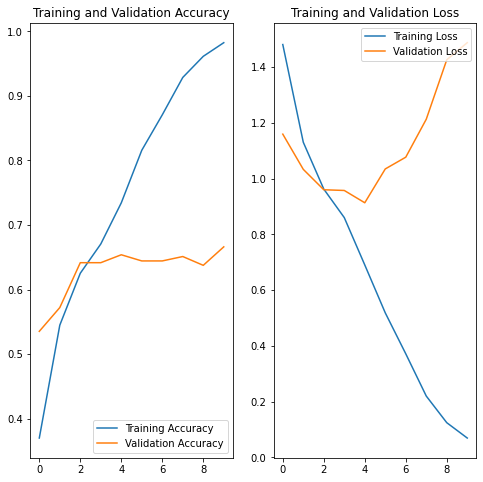

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()